### Pymc and Pooling

Problem Setup

In our example, we need to sample posterior and find its maximize value using PyMC. The data we have in this problem is the score difference between two teams. We agree to use the following formula to calculate the score difference

$$diff = GuestScore(PTS) - HostScore(PTS.1)$$

The score difference(diff) follows a Gaussian distribution $N(\mu,\sigma)$. The $\mu$ is determined by:

$$(O_i - D_j ) - (O_j - D_i)$$ where O is the offensive index and D is the defensive index for one team. Offensive and 

Defensive indexes shall be calculated by the following formulas:

$$   O_{i} = \beta_{i,0}^O + \beta_{i,1}^O x_{i,1} + \beta_{i,2}^O x_{i,2} +\ldots + \beta_{i,J}^O x_{i,J}$$
$$D_{i} = \beta_{i,0}^D + \beta_{i,1}^D x_{i,1} + \beta_{i,2}^D x_{i,2} + \ldots + \beta_{i,J}^D x_{i,J}$$

You can see that $x_i$ is the offensive/defensive rating for each player, we need to figure out $\beta$ in this problem.

Our observed values here are score difference. We assume it follows a normal distribution, which means we could estimate its mean value, then find the $\beta$. 


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

/Users/xdai/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/xdai/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
# This function is to conver the string into int
def Str2float(string):
    try:
        return float(string)
    except:
        return "NaN"

In [25]:
#import 2016
game16_df = pd.read_csv('15-16game_stats.csv')[["Visitor/Neutral", "PTS", "Home/Neutral", "PTS.1"]]
game16_df['Year'] = 2016
game16_df['PTS'] = game16_df['PTS'].map(lambda x: Str2float(x))
game16_df['PTS.1'] = game16_df['PTS.1'].map(lambda x: Str2float(x))
game16_df = game16_df[game16_df['PTS'].map(lambda x: type(x) is float)]
game16_df['diff'] = game16_df['PTS'] - game16_df['PTS.1']

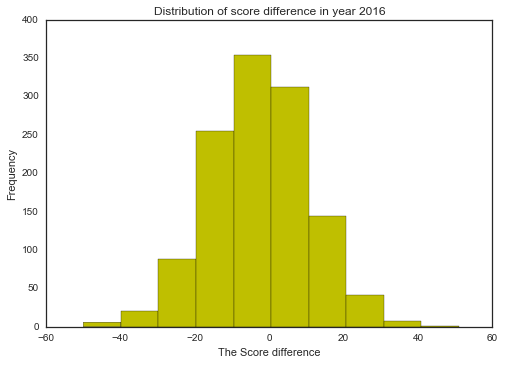

In [34]:
score_diff = game16_df['diff'].values
#plot a histogram
plt.hist(score_diff,color='y')
plt.title("Distribution of score difference in year 2016")
plt.xlabel('The Score difference')
plt.ylabel('Frequency')

In [38]:
# Here we have sigma for the entire data set and assume this sigma as my likehood variance as well
print "The variance of the entire data set is:",np.var(score_diff)

The variance of the entire data set is: 177.785299755


#### As you can see, the score difference follows a normal distribution

In [39]:
#Construct the game stats with each team rosters
#import 2016
game16_df = pd.read_csv('15-16game_stats.csv')[["Visitor/Neutral", "PTS", "Home/Neutral", "PTS.1"]]
game16_df['Year'] = 2016
game16_df['PTS'] = game16_df['PTS'].map(lambda x: Str2float(x))
game16_df['PTS.1'] = game16_df['PTS.1'].map(lambda x: Str2float(x))
game16_df = game16_df[game16_df['PTS'].map(lambda x: type(x) is float)]

In [45]:
#import name and their teams 
playerTeam_df = pd.read_csv('salary.csv', header = 1)[['Player','Tm']]
playerTeam_df = playerTeam_df[playerTeam_df['Tm'] != 'Tm']
playerTeam_df = playerTeam_df[playerTeam_df['Player'] != 'Player']
playerTeam_df = playerTeam_df[~pd.isnull(playerTeam_df['Player'])]

In [43]:
game16_df.head()

,Visitor/Neutral,PTS,Home/Neutral,PTS.1,Year
1,Detroit Pistons,106,Atlanta Hawks,94,2016
2,Cleveland Cavaliers,95,Chicago Bulls,97,2016
3,New Orleans Pelicans,95,Golden State Warriors,111,2016
4,Philadelphia 76ers,95,Boston Celtics,112,2016
5,Chicago Bulls,115,Brooklyn Nets,100,2016


In [46]:
playerTeam_df.head()

,Player,Tm
0,Kobe Bryant,LAL
1,Joe Johnson,BRK
2,LeBron James,CLE
3,Carmelo Anthony,NYK
4,Dwight Howard,HOU


In [3]:
#offensive Rating
player_df2 = pd.read_csv('15-16Per100Pos_stats.csv')[['Player','ORtg']]
player_df2 = player_df2[player_df2['ORtg'] != "ORtg"]
player_df2 = player_df2[~pd.isnull(player_df2['ORtg'])] 
player_df2['ORtg'] = player_df2['ORtg'].map(lambda x: int(x))
player_df2 = pd.DataFrame(player_df2.groupby('Player')['ORtg'].mean())
player_df2["Player"] = player_df2.index
player_df2 = player_df2.reset_index(drop=True)
player_df2.head()

,ORtg,Player
0,99,Aaron Brooks
1,114,Aaron Gordon
2,77,Aaron Harrison
3,81,Adreian Payne
4,113,Al Horford
